# Using dGPS on GLE to Validate the Fusion Strategy

In [1]:
# ruff: noqa: E402
%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl
import dotenv
import matplotlib.pyplot as plt
# Import the scienceplots package to access the styles
import scienceplots as sp
# Load the science style
plt.style.use(["science", "ieee"])


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

dotenv.load_dotenv(ROOT.joinpath(".env"))

# add the root to the python path
sys.path.append(str(ROOT))

SHOW_FIGS = False

from src.validation import create_probe_df
from src.validation import error



## Read the GLE Data


In [2]:
# Length of the GLE
veh_df = create_probe_df.open_probe_df(
    Path(os.environ["PROBE_DATA_DIR"]) / "2023-10-31.Probe.parquet"
)

## Create the Network


In [3]:
import geopandas as gpd
from src.geometry import RoadNetwork

mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
    step_size=0.01,
)

full_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=None,
    step_size=0.01,
)

LANE_WIDTH = 3.55
LANE_NUM = 2

## Snap the Vehicle Trajectories to Lanes


In [4]:
veh_df = create_probe_df.snap_to_lane(
    df=veh_df,
    mainline_net=mainline_net,
    full_net=full_net,
)

veh_df = create_probe_df.build_continous_segment_df(veh_df)

## Read in the Radar Trajectories 

Both the prcessed and unprocessed.

### Raw Radar Data

In [5]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df
from src.pipelines.association import add_front_back_s
from src.pipelines.kalman_filter import prepare_frenet_measurement
from src.pipelines.lane_classification import label_lanes_tree


radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "october_calibrated.yaml",
)


raw_radar_df = (
    pl.scan_parquet(
        "/home/max/Desktop/DOECV2X/Working_Papers/radar-trajectory-extraction/raw_data/2023-10-31.Radar.parquet",
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(minutes=1),
            pl.col("gps_time").max() + timedelta(minutes=1),
        )
    )
    .with_columns(
        (pl.col("f32_positionX_m") ** 2 + pl.col("f32_positionY_m") ** 2)
        .sqrt()
        .alias("dist"),
    )
    .filter(
        pl.when(pl.col("ip").is_in(["10.160.7.141", "10.160.7.137"]))
        .then(pl.col("dist") < 300)
        .otherwise(pl.lit(True))
    )
    .collect()
    .lazy()
    .pipe(prep_df, f=radar_obj)
    .collect()
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=LANE_WIDTH * LANE_NUM
        - (LANE_WIDTH / 2)
        + 0.5,  # centered on one of the lanes,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .with_columns(
        (pl.col("dist").diff().backward_fill(1).over("object_id") < 0).alias(
            "approaching"
        ),
        pl.col("s").cast(pl.Float32).alias("s"),
    )
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
    .pipe(prepare_frenet_measurement)
    .pipe(add_front_back_s, use_median_length=False, use_nearest_length=False)
    .with_columns(
        ((pl.col("back_s") + pl.col("front_s")) / 2).cast(pl.Float32).alias("s"),
    )
    .sort("epoch_time")
    .collect()
    .pipe(
        label_lanes_tree,
        full_network=full_net,
        kalman_network=mainline_net,
        lane_width=LANE_WIDTH,
        s_col="s",
        time_col="epoch_time",
    )
    .drop("s_lane")
    .rename({"s": "centroid_s"})
)


transformations = [
    ("front_s", "d", "front_x", "front_y"),
    ("back_s", "d", "back_x", "back_y"),
    ("centroid_s", "d", "centroid_x", "centroid_y"),
]

for s_col, d_col, x_col, y_col in transformations:
    raw_radar_df = (
        raw_radar_df.pipe(
            mainline_net.frenet2xy,
            lane_col="lane",
            s_col=s_col,
            d_col=d_col,
        )
        .drop(["s", "angle"])
        .rename({"x_lane": x_col, "y_lane": y_col})
    )

function: create_object_id took: 0.00019097328186035156 seconds
function: filter_short_trajectories took: 0.00028061866760253906 seconds
function: clip_trajectory_end took: 0.00021219253540039062 seconds
function: resample took: 0.00021076202392578125 seconds
function: set_timezone took: 4.363059997558594e-05 seconds
function: add_cst_timezone took: 2.6941299438476562e-05 seconds
function: add_heading took: 3.266334533691406e-05 seconds
function: rotate_radars took: 0.0004544258117675781 seconds
function: update_origin took: 0.0003457069396972656 seconds
function: add_front_back_s took: 7.033348083496094e-05 seconds


### Read in the Processed Radar Data

In [6]:
processed_radar_df = pl.read_parquet(
    ROOT / "tmp/fused_10_31.parquet",
)

processed_radar_df.head()

shape: (5, 50)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_inde ┆ ci_s      ┆ ci_s_velo ┆ ci_s_acce ┆ … ┆ ci_back_y ┆ ci_centro ┆ ci_centro ┆ epoch_ti │
│ x         ┆ ---       ┆ city      ┆ l         ┆   ┆ ---       ┆ id_x      ┆ id_y      ┆ me_cst   │
│ ---       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---      │
│ u32       ┆           ┆ f32       ┆ f32       ┆   ┆           ┆ f64       ┆ f64       ┆ datetime │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ [ms, US/ │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Central] │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 20.352004 ┆ 25.090288 ┆ 0.0       ┆ … ┆ 3.6773e6  ┆ 441955.18 ┆ 3.6773e6  ┆ 2023-10- │
│           ┆           ┆           ┆           ┆   ┆           ┆ 7156      ┆           ┆ 31 12:03 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ :24.200  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ CDT      │
│ 0         ┆ 20.778865 ┆ 19.145441 ┆ 0.0       ┆ … ┆ 3.6777e6  ┆ 443542.60 ┆ 3.6777e6  ┆ 2023-10- │
│           ┆           ┆           ┆           ┆   ┆           ┆ 5451      ┆           ┆ 31 11:43 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ :25.800  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ CDT      │
│ 0         ┆ 20.844226 ┆ 24.354546 ┆ 0.0       ┆ … ┆ 3.6773e6  ┆ 441955.84 ┆ 3.6773e6  ┆ 2023-10- │
│           ┆           ┆           ┆           ┆   ┆           ┆ 1665      ┆           ┆ 31 11:48 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ :51.700  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ CDT      │
│ 0         ┆ 21.767016 ┆ 23.698126 ┆ 0.0       ┆ … ┆ 3.6773e6  ┆ 441956.42 ┆ 3.6773e6  ┆ 2023-10- │
│           ┆           ┆           ┆           ┆   ┆           ┆ 5452      ┆           ┆ 31 12:01 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ :58.800  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ CDT      │
│ 1         ┆ 22.870382 ┆ 25.094877 ┆ 0.001851  ┆ … ┆ 3.6773e6  ┆ 441957.60 ┆ 3.6773e6  ┆ 2023-10- │
│           ┆           ┆           ┆           ┆   ┆           ┆ 0679      ┆           ┆ 31 12:03 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ :24.300  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ CDT      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

#### Remove any Bad Matches in the Association

In [7]:
processed_radar_df["vehicle_id"].n_unique()

4029

### Read in the Imtermediate IMM Filtered Data

In [8]:
imm_filter_df = (
    pl.scan_parquet("/media/HDD/max/radar-data/october/cache/imm_filter_joined_df.parquet")
    .filter(~pl.col("prediction"))
    .collect()
    .pipe(
        label_lanes_tree,
        full_network=full_net,
        kalman_network=mainline_net,
        lane_width=LANE_WIDTH,
        s_col="s",
        time_col="epoch_time",
    )
    .drop("s_lane")
    .rename({"s": "centroid_s"})
)


transformations = [
    ("front_s", "d", "front_x", "front_y"),
    ("back_s", "d", "back_x", "back_y"),
    ("centroid_s", "d", "centroid_x", "centroid_y"),
]

for s_col, d_col, x_col, y_col in transformations:
    imm_filter_df = (
        imm_filter_df.pipe(
            mainline_net.frenet2xy,
            lane_col="lane",
            s_col=s_col,
            d_col=d_col,
        )
        .drop(["s", "angle"])
        .rename({"x_lane": x_col, "y_lane": y_col})
    )

## Calculate the Optimal Time Offset b/ Radar and GPS

### Crop the Probe Trajectories to the 95th Quantile of Distance From the Radar

In [9]:
crop_s = processed_radar_df.group_by(["lane", "lane_index"]).agg(
    pl.col("ci_front_s").quantile(0.05).alias("quanitile_5"),
    pl.col("ci_front_s").quantile(0.95).alias("quanitile_95"),
)

In [10]:
veh_df = create_probe_df.crop_quantile_df(
    df=veh_df,
    crop_df=crop_s,
)

### Find the Optimal Offset

In [11]:
error_summary_df = error.find_opt_time(
    veh_df=veh_df,
    radar_df=processed_radar_df,
)

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


error_summary_df_seconds = (
    error_summary_df.group_by("second_offset")
    .agg(
        pl.col("min_rmse").min().alias("min_rmse"),
        pl.col("min_s_velocity_rmse").min().alias("min_s_velocity_rmse"),
    )
    .sort("second_offset")
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_rmse"],
        name="RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_s_velocity_rmse"],
        name="Speed RMSE",
    ),
    secondary_y=True,
)

fig.update_layout(
    height=800,
    width=1200,
    xaxis_title="Second Offset",
    yaxis_title="RMSE",
    yaxis2_title="Speed RMSE",
)

### Implement the Offset and Try to Cluster the Matching Vehicles

In [13]:
optimal_offset = error_summary_df_seconds.sort("min_rmse")["second_offset"][0]
optimal_offset = -15.5
print(f"Optimal offset: {optimal_offset}")

Optimal offset: -15.5


## Find the Vehicles that Best Match the GPS


In [14]:
scatter_df = error.find_per_track_error(
    veh_df=veh_df,
    radar_df=processed_radar_df,
    second_offset=optimal_offset,
)

In [15]:
# try to make two clusters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2).fit(scatter_df[["s_rmse", "s_velocity_rmse"]].to_numpy())

scatter_df = scatter_df.with_columns(
    cluster=pl.Series(dbscan.labels_).cast(str),
)

In [16]:
import plotly.express as px


fig = px.scatter(
    scatter_df.to_pandas(),
    x="s_rmse",
    y="s_velocity_rmse",
    color="cluster",
    hover_data=["vehicle_id", "sequence_id"],
)

fig.show()

In [17]:
good_cluster = (
    scatter_df.group_by("cluster")
    .agg(
        pl.col("s_rmse").mean().alias("s_rmse"),
    )
    .sort("s_rmse")["cluster"][0]
)

print(f"Good cluster: {good_cluster}")

Good cluster: 1


In [18]:
good_matches = scatter_df.filter(pl.col("cluster") == good_cluster)

In [19]:
object_ids = (
    processed_radar_df.filter(
        pl.col("vehicle_id").is_in(good_matches["vehicle_id"].unique())
    )[["vehicle_id", "object_id"]]
    .unique()
    .explode("object_id")
)

## Calculate the Positional Error

We filter out short matches, as this happened when the vehicle crossed the lanes during turning movements

In [20]:
veh_df = veh_df.filter(pl.count().over("sequence_id") > 150)

In [21]:
raw_radar_df = raw_radar_df.filter(
    pl.col("object_id").is_in(object_ids["object_id"])
).join(
    object_ids,
    on="object_id",
)


imm_filter_df = imm_filter_df.filter(
    pl.col("object_id").is_in(object_ids["object_id"])
).join(
    object_ids,
    on="object_id",
)

# raw_error_df.head()

### Build a Paired DataFrame

In [22]:
error_df = error.paired_df(
    veh_df=veh_df,
    raw_radar_df=raw_radar_df,
    radar_df=processed_radar_df,
    imm_filter_df=imm_filter_df,
    good_matches=good_matches,
    second_offset=optimal_offset,
)

In [23]:
veh_df = veh_df.with_columns(
    (
        pl.col("gps_time").cast(error_df["epoch_time"].dtype)
        + timedelta(seconds=optimal_offset)
    ).alias("epoch_time"),
)

In [24]:
import plotly.graph_objects as go


fig = go.Figure()

error_df = error_df.sort("epoch_time")

# plot all the EB trajectories
for g, seq_df in error_df.group_by("sequence_id", maintain_order=True):
    seq_df = seq_df.sort("epoch_time").gather_every(10)

    if seq_df["vehicle_id"].unique().to_list() == [None]:
        continue

    veh_data = (
        veh_df.filter(pl.col("sequence_id") == g)
        .with_columns(pl.col("epoch_time"))
        .gather_every(10)
    )

    fig.add_trace(
        go.Scatter(
            x=veh_data["epoch_time"],
            y=veh_data["front_s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
            showlegend=False,
        ),
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=seq_df["epoch_time"],
    #         y=seq_df["front_s_raw"],
    #         mode="markers",
    #         name=f"Sequence {g}",
    #         marker_color="green",
    #         showlegend=False,
    #     ),
    # )

    # fig.add_trace(
    #     go.Scatter(
    #         x=seq_df["epoch_time"],
    #         y=seq_df["front_s_imm"],
    #         mode="markers",
    #         name=f"Sequence {g}",
    #         marker_color="purple",
    #         showlegend=False,
    #     ),
    # )

    colors = dict(
        zip(seq_df["vehicle_id"].unique().to_list(), px.colors.qualitative.Plotly)
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["front_s_smooth"],
            mode="markers ",
            name=f"Sequence {g}",
            # make the color by the vehicle id
            marker_color=seq_df["vehicle_id"].replace(colors),
            # line_color=seq_df["vehicle_id"].map_dict(colors),
            showlegend=False,
        ),
    )
    # # plot the trajectories


# if SHOW_FIGS:
fig.show()

In [25]:
error_df.head()

shape: (5, 109)
┌──────┬────────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ seq  ┆ gps_time   ┆ lat       ┆ lon        ┆ … ┆ length_s_i ┆ merged_tra ┆ raw_traje ┆ imm_traje │
│ ---  ┆ ---        ┆ ---       ┆ ---        ┆   ┆ mm         ┆ jectory_le ┆ ctory_len ┆ ctory_len │
│ u32  ┆ datetime[μ ┆ f64       ┆ f64        ┆   ┆ ---        ┆ ngth       ┆ gth       ┆ gth       │
│      ┆ s, UTC]    ┆           ┆            ┆   ┆ f64        ┆ ---        ┆ ---       ┆ ---       │
│      ┆            ┆           ┆            ┆   ┆            ┆ f64        ┆ f64       ┆ f64       │
╞══════╪════════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 2696 ┆ 2023-10-31 ┆ 33.235858 ┆ -87.610591 ┆ … ┆ null       ┆ 316.390577 ┆ 316.39057 ┆ 0.0       │
│      ┆ 16:48:00.4 ┆           ┆            ┆   ┆            ┆            ┆ 7         ┆           │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆           ┆           │
│ 2697 ┆ 2023-10-31 ┆ 33.235855 ┆ -87.610598 ┆ … ┆ null       ┆ 316.390577 ┆ 316.39057 ┆ 0.0       │
│      ┆ 16:48:00.5 ┆           ┆            ┆   ┆            ┆            ┆ 7         ┆           │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆           ┆           │
│ 2698 ┆ 2023-10-31 ┆ 33.235852 ┆ -87.610606 ┆ … ┆ null       ┆ 316.390577 ┆ 316.39057 ┆ 0.0       │
│      ┆ 16:48:00.6 ┆           ┆            ┆   ┆            ┆            ┆ 7         ┆           │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆           ┆           │
│ 2699 ┆ 2023-10-31 ┆ 33.235848 ┆ -87.610614 ┆ … ┆ null       ┆ 316.390577 ┆ 316.39057 ┆ 0.0       │
│      ┆ 16:48:00.7 ┆           ┆            ┆   ┆            ┆            ┆ 7         ┆           │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆           ┆           │
│ 2700 ┆ 2023-10-31 ┆ 33.235845 ┆ -87.610622 ┆ … ┆ null       ┆ 316.390577 ┆ 316.39057 ┆ 0.0       │
│      ┆ 16:48:00.8 ┆           ┆            ┆   ┆            ┆            ┆ 7         ┆           │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆           ┆           │
└──────┴────────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

## Analyze the Error

In [26]:
raw_pred_col_func = lambda col_suffix: f"{col_suffix}_raw"  # noqa: E731

raw_error_df = error.calculate_errors(
    error_df.filter(pl.col("object_id").is_not_null()), raw_pred_col_func, ["object_id"]
)

### Length Estimation Error

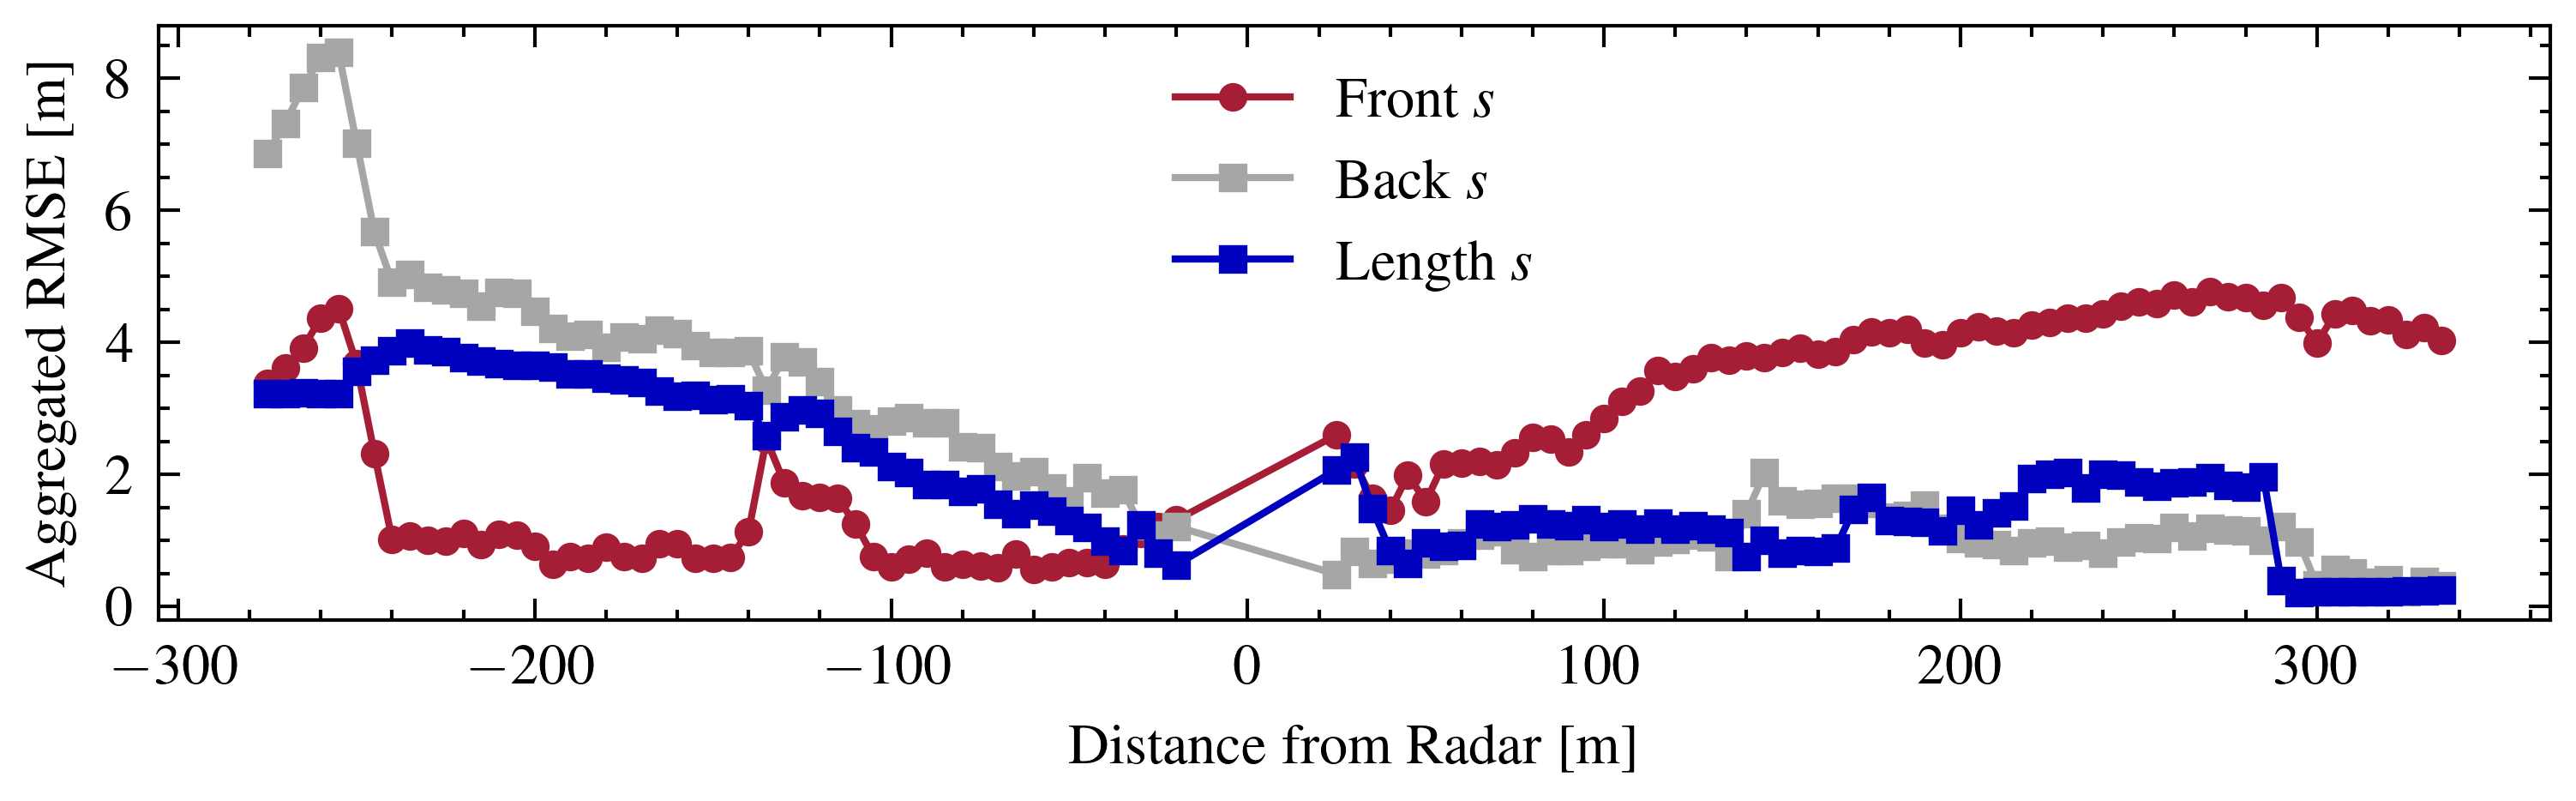

In [27]:
dist_error_ip = (
    raw_error_df.with_columns(
        pl.when(pl.col("approaching"))
        .then(pl.col("dist_raw") * -1)
        .otherwise(pl.col("dist_raw"))
        .alias("dist_raw")
    )
    .sort("dist_raw")
    .group_by_dynamic(
        index_column=(pl.col("dist_raw")).cast(int),
        every="5i",
    )
    .agg(
        pl.col("front_s_se").mean().sqrt(),
        pl.col("back_s_se").mean().sqrt(),
        pl.col("length_s_se").mean().sqrt(),
    )
    # .sort(
    #     [
    #         "ip",
    #     ]
    # )
    .to_pandas()
)


# Assuming dist_error_ip is a Pandas DataFrame with the correct columns
# If not, you should convert it to a Pandas DataFrame first


engine_color = [0.65, 0.65, 0.65]
gps_color = [0, 0, 0.75]
plutron_color = [0, 0, 0]
alabama = [165, 30, 54]
alabama = [i / 255 for i in alabama]

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(6, 1.5))

# Plot the data with line and markers
ax.plot(
    dist_error_ip["dist_raw"],
    dist_error_ip["front_s_se"],
    label="Front $s$",
    marker="o",
    linestyle="-",
    linewidth=1,
    markersize=3,
    color=alabama,
)
ax.plot(
    dist_error_ip["dist_raw"],
    dist_error_ip["back_s_se"],
    label="Back $s$",
    marker="s",
    linestyle="-",
    linewidth=1,
    markersize=3,
    color=engine_color,
)
ax.plot(
    dist_error_ip["dist_raw"],
    dist_error_ip["length_s_se"],
    label="Length $s$",
    marker="s",
    linestyle="-",
    linewidth=1,
    markersize=3,
    color=gps_color,
)

# Set the x and y axis labels
ax.set_xlabel("Distance from Radar [m]")
ax.set_ylabel("Aggregated RMSE [m]")

# show the legend
ax.legend()

In [28]:
import pandas as pd

def latex_mapper(s: str) -> str:
    return {
        "d": "$d$ [m]",
        "s": "$s$ [m]",
        "xy": "$(x, y)$ [m]",
        "coverage": "Coverage [\%]",
        "None": "-",
        "speed": "$\mu$ [m/s]",
    }[s]


def split_and_capitalize(metric):
    parts = metric.split("_")
    if len(parts) == 3:
        return (parts[-1].upper(), parts[0].title(), latex_mapper(parts[1]))
    else:
        return (metric.title(), None, None)


pretty_df = (
    error.build_error_df(error_df)
)

pretty_df = (
    pretty_df
    .drop(["method", "lane"])
    .to_pandas()
    # make a multi index for the columns (top level is  Front/Back, second level is mse/rmse)
    .set_axis(
        pd.MultiIndex.from_tuples(
            [
                split_and_capitalize(col)
                for col in pretty_df.drop(["method", "lane"]).columns
            ],
            names=["Metric", "Location", "Frame"],
        ),
        axis=1,
    )
    .set_axis(
        pd.MultiIndex.from_frame(
            pretty_df[["method"]].to_pandas(),
            names=["Method"],
        ),
        axis=0,
        # drop=True,
    )
    # .set_index(keys=[("Lane", pd.NA, pd.NA), ("Method", pd.NA, pd.NA,)], drop=True)
    .sort_index()
    .sort_index(axis=1)
)


print(
    pretty_df.drop("Sequence_Id", axis=1).to_latex(
        sparsify=True, float_format="%.2f", index_names=["Lane", "Method"]
    )
)

\begin{tabular}{lrrrrrrrrrr}
\toprule
Metric & PERCENT & \multicolumn{9}{r}{RMSE} \\
Location & Average & \multicolumn{2}{r}{Back} & \multicolumn{3}{r}{Centroid} & \multicolumn{2}{r}{Front} & Length & Speed \\
Frame & Coverage [\%] & $(x, y)$ [m] & $s$ [m] & $(x, y)$ [m] & $d$ [m] & $s$ [m] & $(x, y)$ [m] & $s$ [m] & $s$ [m] & $\mu$ [m/s] \\
Method &  &  &  &  &  &  &  &  &  &  \\
\midrule
ci & 70.65 & 2.04 & 1.97 & 2.36 & 0.52 & 2.30 & 3.65 & 3.61 & 1.43 & 1.00 \\
imm & 33.41 & 2.74 & 1.69 & 3.26 & 0.77 & 2.37 & 2.43 & 1.27 & 0.84 & 0.96 \\
raw & 30.76 & 3.02 & 2.08 & 2.35 & 0.87 & 1.96 & 3.64 & 2.84 & 1.78 & 1.03 \\
smooth & 70.65 & 1.94 & 1.88 & 1.69 & 0.46 & 1.61 & 2.47 & 2.41 & 1.43 & 0.57 \\
\bottomrule
\end{tabular}



In [29]:
pretty_df

Metric         PERCENT         RMSE                                   \
Location       Average         Back               Centroid             
Frame    Coverage [\%] $(x, y)$ [m]   $s$ [m] $(x, y)$ [m]   $d$ [m]   
Method                                                                 
ci           70.651537     2.040994  1.965324     2.358561  0.519626   
imm          33.408267     2.736866  1.685272     3.257938  0.773171   
raw          30.758028     3.018171  2.077053     2.352353  0.872849   
smooth       70.651537     1.942162  1.880198     1.691990  0.464354   

Metric                                                          Sequence_Id  
Location                  Front              Length       Speed         NaN  
Frame      $s$ [m] $(x, y)$ [m]   $s$ [m]   $s$ [m] $\mu$ [m/s]         NaN  
Method                                                                       
ci        2.296265     3.654356  3.614262  1.425984    1.004845        10.0  
imm       2.372858     2.431968  1.266520  0.835458    0.957893        10.0  
raw       1.958211     3.642163  2.835909  1.777896    1.029899        10.0  
smooth    1.614174     2.473004  2.410413  1.425984    0.573138        10.0

## Plots of Position Vs. Time

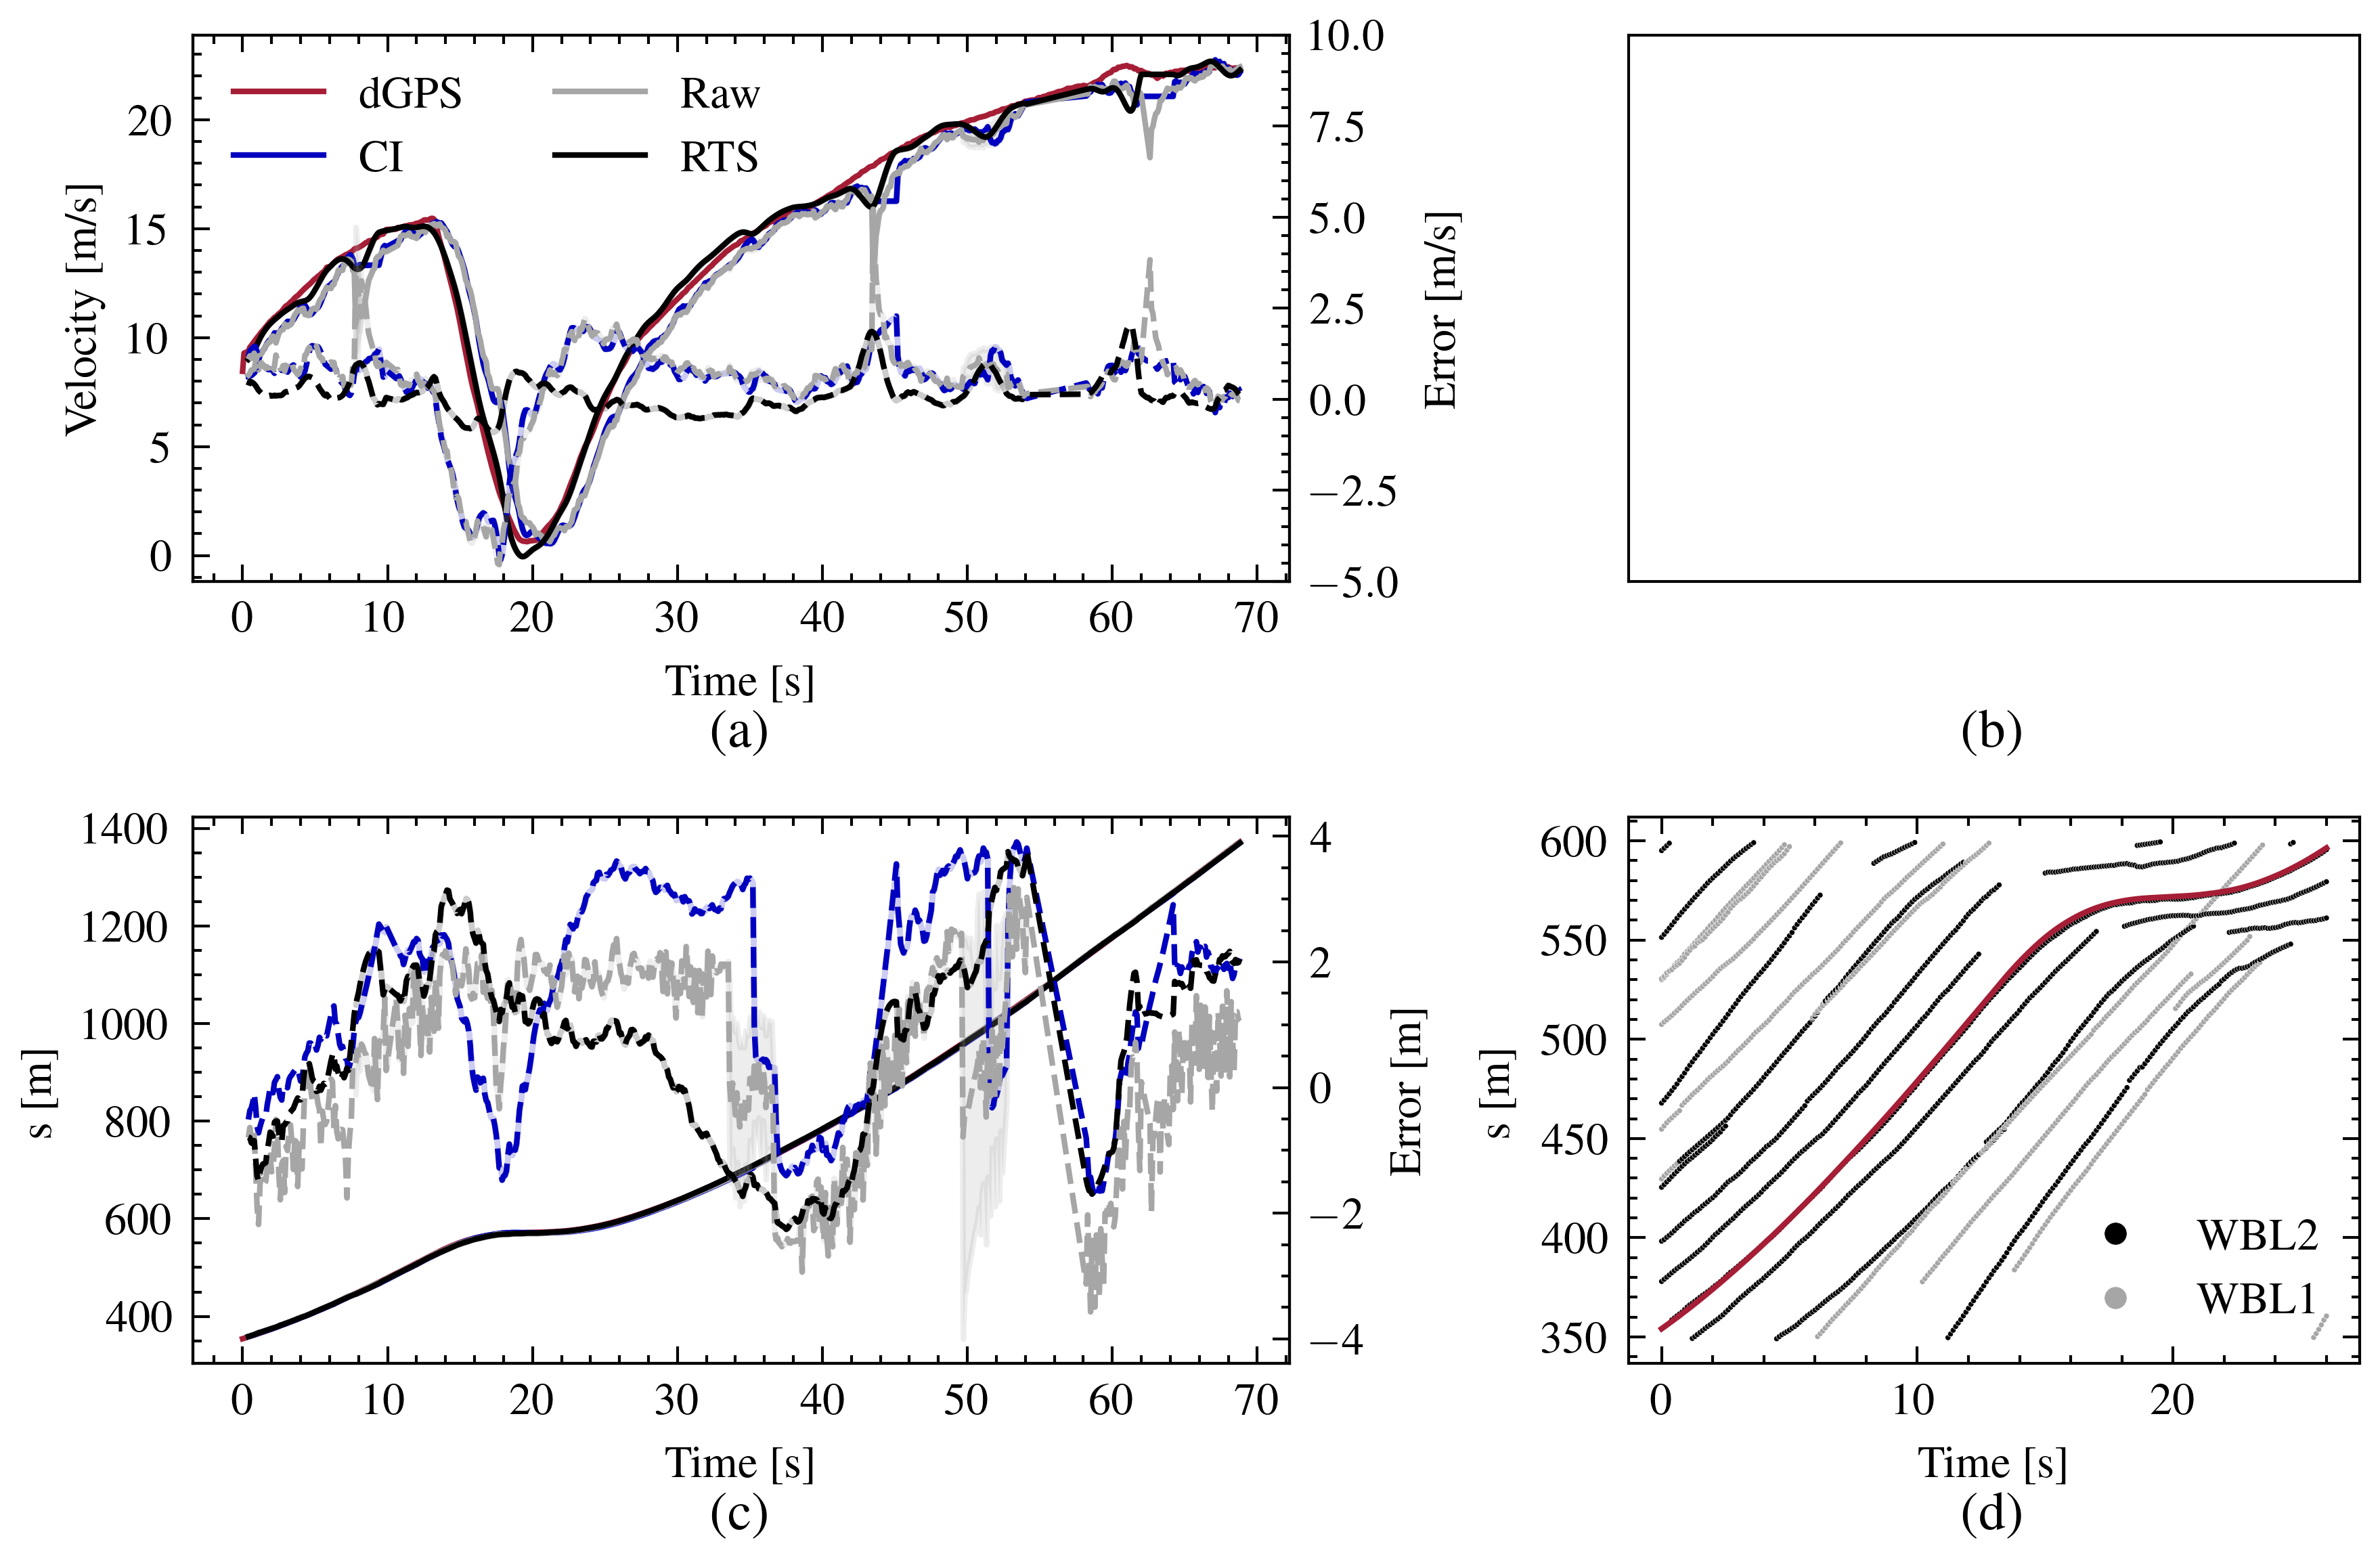

In [30]:
import seaborn as sns
from src.plotting.single_veh import letter_subplots

target_sequence = 13

s_low = 350
s_high = 600

fig, (ax1, ax2) = plt.subplots(
    2,
    2,
    width_ratios=[3, 2],
    figsize=(6, 4),
)
letter_subplots(yoffset=-0.28, xoffset=0.5, letters='(a)')

# remove the ticks
# for a in ax1[:-1]:
ax1[-1].set_xticks([])
ax1[-1].set_yticks([])


plot_error_df = (
    error_df.filter((pl.col("sequence_id") == target_sequence))
    .with_columns(
        pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
    )
    .with_columns(
        (
            (
                pl.col("epoch_time_cst") - pl.col("epoch_time_cst").min()
            ).dt.total_milliseconds()
            / 1000
        ).alias("time")
    )
    # .gather_every(10)
)

plot_veh_df = (
    veh_df.filter((pl.col("sequence_id") == target_sequence))
    .with_columns(
        (pl.col("epoch_time"))
        .dt.convert_time_zone("US/Central")
        .alias("epoch_time_cst"),
    )
    .filter(
        pl.col("epoch_time_cst").is_between(
            plot_error_df["epoch_time_cst"].min(),
            plot_error_df["epoch_time_cst"].max(),
        )
    )
    .with_columns(
        (
            (
                pl.col("epoch_time_cst") - plot_error_df["epoch_time_cst"].min()
            ).dt.total_milliseconds()
            / 1000
        ).alias("time")
    )
)

small_s_veh_df = plot_veh_df.filter(pl.col("front_s").is_between(s_low, s_high))

plot_radar_df = (
    processed_radar_df.sort("epoch_time")
    .with_columns(
        pl.col("epoch_time")
        .dt.convert_time_zone("US/Central")
        .alias("epoch_time_cst"),
    )
    .filter(
        pl.col("epoch_time_cst").is_between(
            small_s_veh_df["epoch_time_cst"].min(),
            small_s_veh_df["epoch_time_cst"].max(),
        )
        & (pl.col("front_s_smooth").is_between(s_low, s_high))
        & pl.col("lane").str.contains("W")
    )
    .with_columns(
        (
            (
                pl.col("epoch_time_cst") - plot_error_df["epoch_time_cst"].min()
            ).dt.total_milliseconds()
            / 1000
        ).alias("time")
    )
)

sns.lineplot(
    small_s_veh_df,
    x="time",
    y="s",
    color=alabama,
    # s=1,
    ax=ax2[1],
)

sns.scatterplot(
    plot_radar_df.select(["time", "s_smooth", "lane_index"]).with_columns(
        pl.col("lane_index").replace({0: "WBL1", 1: "WBL2"})
    ),
    x="time",
    y="s_smooth",
    s=1,
    hue="lane_index",
    palette=[
        plutron_color,
        engine_color,
    ],
    ax=ax2[1],
)

# # update the legend.
handles, labels = ax2[1].get_legend_handles_labels()
ax2[1].legend(handles=handles, labels=labels, markerscale=4)

j = 0
for setup, axes, true_col in zip(
    [
        [
            ("dGPS", "s_velocity", alabama, 5),
            ("CI", "ci_s_velocity", gps_color, 3),
            ("Raw", "s_velocity_raw", engine_color, 3),
            ("RTS", "s_velocity_smooth", plutron_color, 3),
        ],
        [
            ("dGPS", "s", alabama, 5),
            ("CI", "ci_s", gps_color, 3),
            ("Raw", "s_raw", engine_color, 3),
            ("RTS", "s_smooth", plutron_color, 3),
        ],
    ],
    [ax1, ax2],
    ["s_velocity", "s"],
):
    # if true_col == "s":
    mew_ax = axes[0].twinx()
    if j == 0:
        mew_ax.set_ylabel("Error [m/s]")
        mew_ax.set_ylim(-5, 10)
    # else:
    #     mew_ax = axes[0]

    for i, (name, col, color, size) in enumerate(setup):
        plot_df = plot_veh_df if name == "dGPS" else plot_error_df

        plot_df = plot_df.with_columns((pl.col(true_col) - pl.col(col)).alias("error"))

        plot_ = sns.lineplot(
            data=plot_df,
            x="time",
            y=col,
            color=color,
            # s=size,
            label=name if j == 0 else None,
            ax=axes[0],
        )

        if name != "dGPS":
            sns.lineplot(
                data=plot_df,
                x="time",
                y="error",
                color=color,
                # s=size,
                label=None,
                ax=mew_ax,
                linestyle="--",
                # showlegend=False,
            )

    j += 1

ax1[0].sharex(ax2[0])
# only keep some of the ticks
ax1[0].set_ylabel("Velocity [m/s]")
ax2[0].set_ylabel("s [m]")
mew_ax.set_ylabel("Error [m]")
ax2[1].set_ylabel("s [m]")

# set all the x-labels as Time [s]
ax1[0].set_xlabel("Time [s]")
ax2[0].set_xlabel("Time [s]")
ax2[1].set_xlabel("Time [s]")

# set a white background on the legend
ax1[0].legend().get_frame().set_facecolor("white")

# make the legend two columns
ax1[0].legend(ncol=2)


plt.tight_layout()